# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey.rename(columns={'dbn': 'DBN'}, inplace=True)

In [3]:
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11"
]

In [4]:
survey = survey[survey_fields]

In [5]:
data["survey"] = survey

# Add DBN columns

In [6]:
data['hs_directory'].rename(columns={'dbn': 'DBN'}, inplace=True)
data['class_size']['padded_csd'] = data['class_size']['CSD'].astype(str).str.zfill(2)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

# Convert columns to numeric

In [7]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [8]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [9]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [10]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [11]:
combined['school_dist'] = combined['DBN'].str[:2]

# Find correlations

In [13]:
correlations = combined.corr()
correlations = correlations['sat_score']
for index, val in zip(combined.corr().index, correlations):
    print(index, '   -----   ', round(val, 2))

SAT Critical Reading Avg. Score    -----    0.99
SAT Math Avg. Score    -----    0.97
SAT Writing Avg. Score    -----    0.99
sat_score    -----    1.0
AP Test Takers     -----    0.41
Total Exams Taken    -----    0.39
Number of Exams with scores 3 4 or 5    -----    0.38
Total Grads - % of cohort    -----    0.58
Total Regents - % of cohort    -----    0.67
Total Regents - % of grads    -----    0.49
Advanced Regents - % of cohort    -----    0.77
Advanced Regents - % of grads    -----    0.74
Regents w/o Advanced - % of cohort    -----    -0.14
Regents w/o Advanced - % of grads    -----    -0.46
Local - % of cohort    -----    -0.47
Local - % of grads    -----    -0.49
Still Enrolled - % of cohort    -----    -0.49
Dropped Out - % of cohort    -----    -0.46
CSD    -----    0.04
NUMBER OF SECTIONS    -----    0.36
AVERAGE CLASS SIZE    -----    0.38
SIZE OF SMALLEST CLASS    -----    0.25
SIZE OF LARGEST CLASS    -----    0.31
SCHOOLWIDE PUPIL-TEACHER RATIO    -----    nan
schoolyea

# Plotting survey correlations

In [14]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove('DBN')

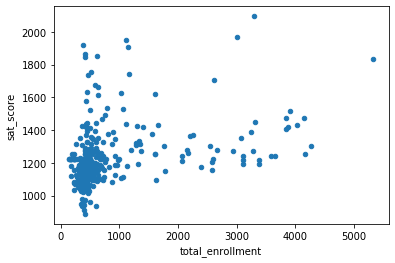

In [15]:
# Plot total enrollment and SAT scores
combined.plot(kind='scatter', x='total_enrollment', y='sat_score')

In [16]:
# List schools with low SAT scores and low enrollment
mask1 = combined['sat_score'] < 1000
mask2 = combined['total_enrollment'] < 1000
mask = mask1 & mask2
low_enrollment = combined[mask]
low_enrollment['School Name']

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

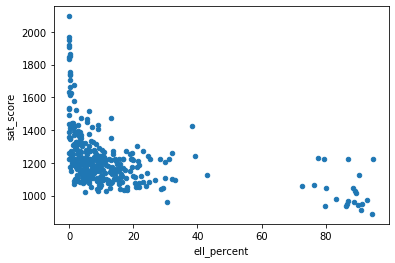

In [17]:
# Plot English language learners percent and SAT scores
combined.plot(kind='scatter', x='ell_percent', y='sat_score')

In [18]:
# Group data by school district
districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Grads - % of cohort,Total Regents - % of cohort,...,expgrade_span_min,expgrade_span_max,number_programs,priority08,priority09,priority10,Community Board,Council District,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,105.876423,140.212500,101.427007,71.333333,66.416667,...,0.0,12.0,1.333333,0.0,0.0,0.0,3.000000,1.500000,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,90.233943,116.819792,78.672141,75.453574,64.166074,...,0.0,12.0,1.416667,0.0,0.0,0.0,4.204005,2.963296,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,143.578049,114.200000,154.417883,74.029937,63.879937,...,0.0,12.0,2.000000,0.0,0.0,0.0,7.500000,6.500000,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,116.668293,146.385714,114.207508,76.257143,57.428571,...,0.0,12.0,1.142857,0.0,0.0,0.0,11.000000,8.000000,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,79.548432,96.978571,105.636079,75.200881,68.872309,...,0.0,12.0,1.142857,0.0,0.0,0.0,9.428571,8.142857,40.817077,-73.949251


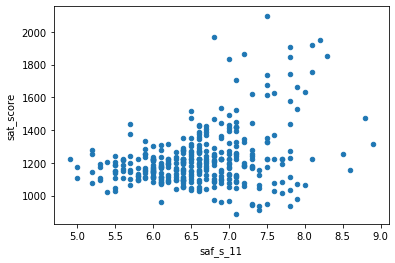

In [19]:
# Plot student school safety scores and SAT scores
combined.plot(kind='scatter', x='saf_s_11', y='sat_score')

It appears that in general, students tend to do better on SATs in schools they view as being safer. Interestingly, the 4 safest schools according to students all have combined SAT scores of less than 1,500.

# Analyze safety scores by borough

In [21]:
safety_scores_by_district = combined[['borough', 'saf_s_11', 'sat_score']]

In [22]:
safety_scores_by_district['sat_score'] = safety_scores_by_district['sat_score'].apply(lambda x: round(x, 0))
safety_scores_by_district['saf_s_11'] = safety_scores_by_district['saf_s_11'].apply(lambda x: round(x, 2))

C:\Users\isemenchuk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\isemenchuk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
safety_scores_by_district = safety_scores_by_district.pivot_table(index='borough', values='saf_s_11')
safety_scores_by_district.reset_index(inplace=True)
safety_scores_by_district

,borough,saf_s_11
0,Bronx,6.606559
1,Brooklyn,6.370755
2,Manhattan,6.831333
3,Queens,6.721875
4,Staten Island,6.530000


According to students' self scores of school safety, the safest schools are in Manhattan (6.83). The least safe schools are in Brooklyn (6.37). Given the fact that scores range from 1 to 10, the range of average safety scores by borough seems to be narrow (6.37 to 6.83)

# Analyze SAT scores by race

In [33]:
safety_scores_by_race = combined[['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']]

In [35]:
safety_scores_by_race = safety_scores_by_race.corr()['sat_score']

In [44]:
safety_scores_by_race.drop('sat_score', inplace=True)

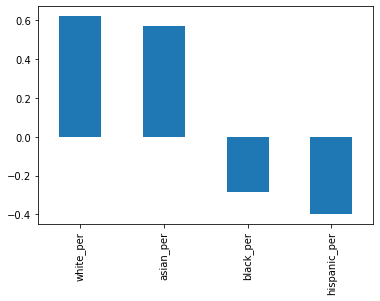

In [45]:
safety_scores_by_race.plot(kind='bar')

Share of White and Asian students shows a strong positive correlation with SAT scores. Share of Black and Hispanic students shows a negative correlation with SAT scores.

### View schools with a high percentage of Hispanic students and low SAT scores

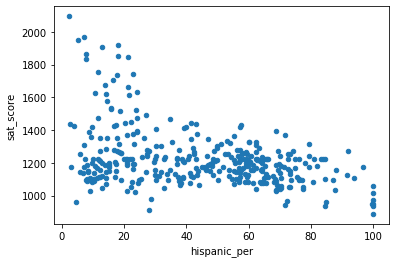

In [46]:
combined.plot(kind='scatter', x='hispanic_per', y='sat_score')

It appears that there is a significant drop off in SAT scores when the percentage of Hispanic students is above 25%. Not a single school has a combined SAT score of above 1,500 where the share of Hispanic students is above 25%. It appears that a few schools that are 100% Hispanic all have combined SAT scores of under 1,100.

In [64]:
hispanic_schools = combined[combined['hispanic_per'] > 95]
hispanic_schools[['SCHOOL NAME', 'sat_score', 'hispanic_per', 'ell_percent', 'sped_percent']]

,SCHOOL NAME,sat_score,hispanic_per,ell_percent,sped_percent
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,99.8,72.6,1.7
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,96.7,19.6,18.1
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,99.8,89.6,0.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,99.4,86.6,0.9
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,99.8,79.9,4.6
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,99.8,92.9,0.2
253,MULTICULTURAL HIGH SCHOOL,887.0,99.8,94.6,1.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,100.0,91.3,0.8


Of 8 schools with a 95%+ share of Hispanic students, 7 schools are in the 73 to 95% range of students who are also English language learners. The 8th school has a 20% share of Hispanic students, and an 18% share of special education students.

### View schools with a low percentage of Hispanic students and  high SAT scores

In [69]:
non_hispanic_high_score_schools = combined[combined['hispanic_per'] < 10]
non_hispanic_high_score_schools = non_hispanic_high_score_schools[non_hispanic_high_score_schools['sat_score'] > 1800]
non_hispanic_high_score_schools['white_asian_per'] = non_hispanic_high_score_schools['white_per'] + non_hispanic_high_score_schools['asian_per']
non_hispanic_high_score_schools[['SCHOOL NAME', 'sat_score', 'hispanic_per', 'white_asian_per', 'black_per', 'ell_percent', 'sped_percent']]

,SCHOOL NAME,sat_score,hispanic_per,white_asian_per,black_per,ell_percent,sped_percent
37,STUYVESANT HIGH SCHOOL,2096.0,2.4,95.8,1.2,0.0,0.4
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,7.2,88.9,3.5,0.1,0.1
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,7.9,81.6,10.2,0.1,0.5
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,7.9,81.1,10.5,0.2,0.2
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,5.3,93.1,1.1,0.1,0.5


5 schools have less than 10% Hispanic students and SAT scores above 1,800. They are magnet schools or schools focused on technical or science education. They also have a combined white and asian share of students of 81 to 96%, less than 1% share of special education students, and a 0% share of English language learners.

# Analyze SAT scores by gender

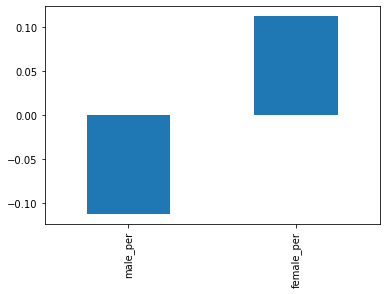

In [73]:
genders_corr = combined[['male_per', 'female_per', 'sat_score']].corr()
genders_corr = genders_corr['sat_score']
genders_corr.drop('sat_score', inplace=True)
genders_corr.plot(kind='bar')

Percentage of male students show a weak negative correlation with SAT scores. Percentage of female students show a weak positive correlation with SAT scores.

### View schools with a high percentage of female students

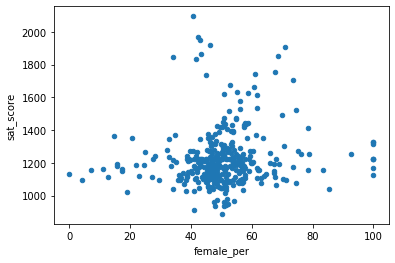

In [74]:
combined.plot(kind='scatter', x='female_per', y='sat_score')

This plot branches in multiple directions, showing that there is no correlation between the percentage of female students and STA scores, or it's very weak.

In [76]:
high_female_pct = combined[combined['female_per'] > 60]
high_female_pct = high_female_pct[high_female_pct['sat_score'] > 1700]
high_female_pct[['SCHOOL NAME', 'sat_score', 'female_per', 'white_per', 'asian_per', 'black_per', 'hispanic_per', 'sped_percent', 'ell_percent']]

,SCHOOL NAME,sat_score,female_per,white_per,asian_per,black_per,hispanic_per,sped_percent,ell_percent
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,68.7,49.8,15.1,15.1,18.2,0.8,0.2
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,67.5,63.7,17.2,5.5,11.6,1.2,0.2
60,BEACON HIGH SCHOOL,1744.0,61.0,49.8,8.9,14.6,22.8,3.7,0.2
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,73.6,49.2,19.6,12.9,16.6,1.0,0.2
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,71.1,24.6,55.5,5.9,12.9,0.2,0.0


5 schools have more than 60% female students and SAT scores above 1,700. 1 of these has 80% share of White and Asian students and an SAT score of 1,910. These schools have a strong focus on college prep or performing arts.

# Analyze Relationship of AP test takers and SAT Scores

In [77]:
# Calculate percentage of students who took an AP test
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

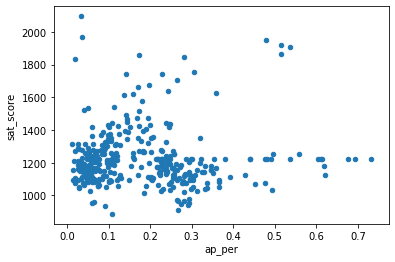

In [78]:
combined.plot(kind='scatter', x='ap_per', y='sat_score')

The graph seems to branch out in 3 directions, which is not a good sign to claim correlation between AP test taking and SAT scores.